## Comparing Arecibo, VLA, and Effelsberg constraints on FRB 121102 burst spectra
### Build broad band spectra of FRB for Law et al 2017

Note that this notebook assumes rtpipe <= v1.54, which has an error in the DM scale.

Starting at v1.55, the DM scale factor changed from 4.2e-3 to 4.1488e-3. 

This effectively changes the DM scale by 1.2%, so DM=560.5 (in v 1.54) is actually 567.4 (in v1.55 and in other codes and in reality).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as pl
import astropy.io.fits as fits

import rtpipe
import rtlib_cython as rtlib

import astropy.units as units
import astropy.coordinates as coord
from astropy.time import Time

2017-05-21 20:05:08,745 - py.warnings - WARNING - /Users/caseyjlaw/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



In [3]:
# confirm version is is earlier than 1.54 if using old dm scale
print(rtpipe.__version__)

1.53


## Useful functions

In [4]:
dmdelay_new = lambda dm, f0, f1: 4.1488e-3*dm*(1./f0**2 - 1./f1**2)  # inconsistent with rtpipe
dmdelay = lambda dm, f0, f1: 4.2e-3*dm*(1./f0**2 - 1./f1**2)  # consistent with rtpipe, but requires scaling by 1.2%

## Read coherently dedispersed Arecibo dynamic spectrum

In [5]:
#name = 'puppi_57648_C0531+33_0048_3756.99.ar.paz'
name = 'puppi_57648_C0531+33_0048_3757.00.ar.paz.pT'
fits.info(name)

Filename: puppi_57648_C0531+33_0048_3757.00.ar.paz.pT
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      64   ()      
  1  HISTORY     BinTableHDU     71   3R x 28C   [24A, 256A, 8A, 8A, 1J, 1I, 1I, 1I, 1D, 1D, 1J, 1D, 1D, 1D, 1I, 1I, 1I, 1I, 1I, 32A, 32A, 32A, 256A, 32A, 32A, 1I, 32A, 1I]   
  2  PSRPARAM    BinTableHDU     12   7R x 1C   [128A]   
  3  POLYCO      BinTableHDU     38   1R x 13C   [24A, 16A, 1I, 1I, 1I, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 15D]   
  4  SUBINT      BinTableHDU     72   1R x 10C   [1D, 1D, 1D, 1D, 1D, 512D, 512E, 512E, 512E, 2097152I]   


In [6]:
hdu = fits.open(name)
hdu0, hdu1, hdu2, hdu3, hdu4 = hdu[0], hdu[1], hdu[2], hdu[3], hdu[4]

In [7]:
hdu0.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
HDRVER  = '5.4             '   / Header version                                 
FITSTYPE= 'PSRFITS         '   / FITS definition for pulsar data files          
DATE    = '2017-03-10T14:23:

## Define python names for Arecibo header info

In [8]:
nch0 = 512
obsfreq = 1780.
df = 1.5625
tint0 = 2.04780080448418e-05
#dm0 = 560.5
dm0 = 553.7  # equivalent to 560.5 in correct scaling

dmt_ao = dmdelay(dm0, obsfreq*1e-3, 1e4)/(24*3600)
bary_ao = 75.7555109 # seconds, from presto
mjd0 = int(57648) # subtract this for convenience. must be an integer mjd
#mjdfrac_ao = (37750 + 0.319370962786796)/(24*3600) - dmt_ao # start time from header
#mjdfrac_ao = (37750 + 0.336629511829426)/(24*3600) - dmt_ao # start time from header, second round
mjdfrac_ao = 57648.43692057008 - dmt_ao - mjd0 + bary_ao/(24*3600)

nint0 = 4096
dt_ao = tint0*nint0

## Read dynamic spectrum and average down a bit
### Define time/freq binning and barycentric time grid for Arecibo data

In [9]:
tbin = 8
nint1 = nint0/tbin
tint0 = dt_ao/nint0
print('Orig time resolution {0}'.format(tint0))
tint1 = tint0*tbin
print('New time resolution {0}'.format(tint1))

data = fits.getdata(name, ext=4)
spec = data[0][9]  # spectrum read as (npol, nchan, nint) array
specI = spec[:2].mean(axis=0)  # average over first two to get stokes I **confirm**
specI = specI.reshape(nch0, nint1, tbin).mean(axis=2)  # use array slicing to rebin

# flag bad channels
flagch = range(0, 16) + [99, 100, 101, 286, 287, 310, 311] + range(320, 356) + range(nch0-110, nch0)
specI[flagch] = 0
specI = np.ma.masked_equal(specI, 0)

fbin = 2
nch1 = nch0/fbin
print('Orig freq resolution {0}'.format(df))
print('New freq resolution {0}'.format(df*fbin))
specAO = specI.reshape(nch1, fbin, nint1).mean(axis=1)  # use array slicing to rebin
meanspec = specAO.mean(axis=1)
specAO = specAO - meanspec[:,None]

specAO = (specAO-np.ma.mean(specAO))/np.ma.std(specAO)  # convert to snr per pixel
#specAO = specAO/5  # scale by gain relative to VLA?
print(specAO.shape)

tbary_ao = np.linspace(mjdfrac_ao, mjdfrac_ao+(dt_ao/(24*3600)), nint1)
freqs_ao = np.linspace(obsfreq - fbin*df*nch1, obsfreq, nch1)

extent_ao = (tbary_ao[0], tbary_ao[-1], freqs_ao[0], freqs_ao[-1])

Orig time resolution 2.04780080448e-05
New time resolution 0.000163824064359
Orig freq resolution 1.5625
New freq resolution 3.125
(256, 512)


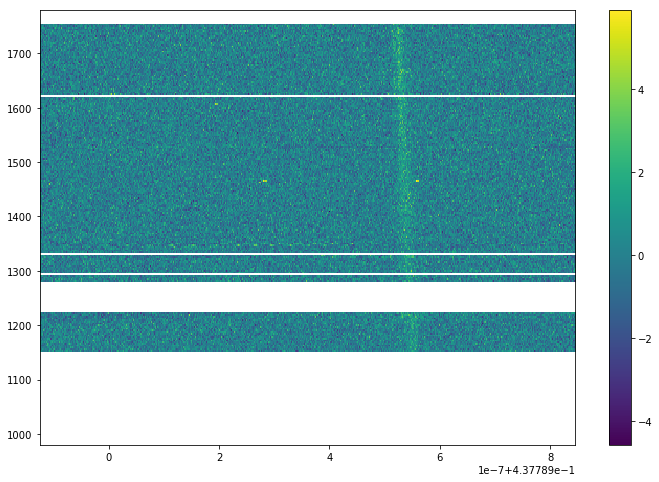

In [10]:
fig = pl.figure(figsize=(12,8))
pl.imshow(specAO, interpolation='nearest', aspect='auto', extent=extent_ao)
pl.colorbar()

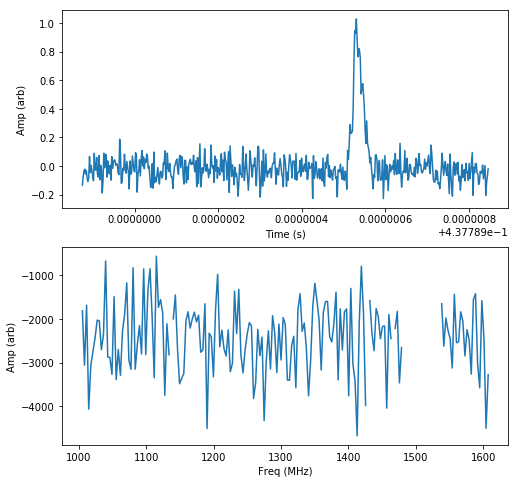

In [11]:
pl.figure(figsize=(8,8))
pl.subplot(211)
pl.plot(tbary_ao, specAO.mean(axis=0))
pl.ylabel('Amp (arb)')
pl.xlabel('Time (s)')
pl.subplot(212)
pl.plot(freqs_ao, meanspec)
pl.xlabel('Freq (MHz)')
pl.ylabel('Amp (arb)')

## Arecibo burst SNR

In [12]:
sp = specAO.reshape(nch1, nint1/16, 16).mean(axis=2)
print(sp.mean(axis=0).max()/sp.mean(axis=0)[:20].std())

38.87800296


In [13]:
tpk_ao = tbary_ao[np.where(specAO.mean(axis=0) == specAO.mean(axis=0).max())][0]
print('%.10f' % tpk_ao)

0.4377895303


## crude integrated flux measurement

In [14]:
sigma = 4
peakbins = np.where(specAO.mean(axis=0) >= sigma*specAO.mean(axis=0)[:256].std())
peaktimes = tbary_ao[peakbins]
window = (peaktimes.max()-peaktimes.min())*24*3600
print('{0} sigma limit selects {1} ms of pulse ({2} bins)'.format(sigma, 
                                                                  window*1e3, 
                                                                  len(peaktimes)))
print('Window width is a bit wider than properly-dedispersed pulse, due to extra sweep')

4 sigma limit selects 2.7904592093 ms of pulse (16 bins)
Window width is a bit wider than properly-dedispersed pulse, due to extra sweep


In [15]:
Sint_sys = specAO.mean(axis=0)[peakbins].mean()
noise = specAO.mean(axis=0)[:peakbins[0][0]].std()/np.sqrt(len(peaktimes))

Sint = (3./np.sqrt(600e6*window*2))*Sint_sys/noise
print('Integrated flux density over {0} ms pulse: {1} mJy'.format(window, Sint*1e3))

Integrated flux density over 0.0027904592093 ms pulse: 57.057635674 mJy


In [16]:
Sspec_sys = specAO[:, peakbins[0]].mean(axis=1)
noise_spec = specAO[:, :peakbins[0][0]].std()/np.sqrt(len(peaktimes))
Sspec = (3./np.sqrt(3.125e6*window*2))*Sspec_sys/noise_spec
print('A (less good) integrated flux density over 2 ms pulse: {0} mJy'.format(int(Sspec.mean()*1e3)))

A (less good) integrated flux density over 2 ms pulse: 62 mJy


## Make nice Arecibo burst spectrum like the VLA ones

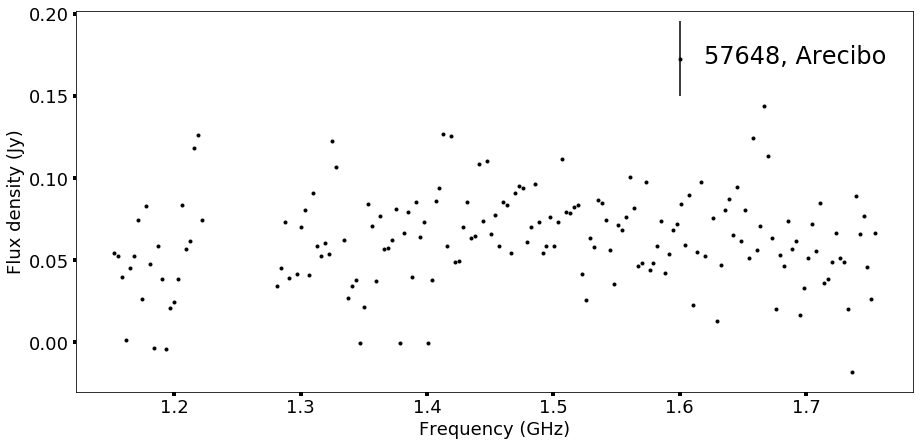

In [17]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)
pl.plot(1e-3*freqs_ao[::-1], Sspec, 'k.')
pl.text(0.75, 0.88, '57648, Arecibo', horizontalalignment='left', fontsize=24,
        verticalalignment='center', transform=ax.transAxes)
pl.errorbar(1.600, 1.2*Sspec.max(), yerr=(3./np.sqrt(3.125e6*window*2)), fmt='k.', ecolor='k')
pl.ylim(-0.03, Sspec.max()*1.4)
pl.xlabel('Frequency (GHz)', fontsize=18)
pl.ylabel('Flux density (Jy)', fontsize=18)
xt = pl.setp(ax.get_xticklabels(), fontsize=18)
yt = pl.setp(ax.get_yticklabels(), fontsize=18)
ax.xaxis.set_tick_params(width=4, color='k')
ax.yaxis.set_tick_params(width=4, color='k')
fig.savefig('specAO_57648.pdf', format='pdf')

## VLA
### Set calibration table and set useful functions for rtpipe

In [18]:
calstring = """2.0520    2.89698    0.00279
2.1800    *******    *******
2.3080    *******    *******
2.4360    3.53585    0.00377
2.5640    3.69554    0.00376
2.6920    3.85507    0.00423
2.8200    4.00438    0.00486
2.9480    4.11069    0.00562
3.0520    4.20375    0.00631
3.1800    4.29385    0.00662
3.3080    4.36557    0.00715
3.4360    4.43684    0.00786
3.5640    4.46937    0.00850
3.6920    4.52488    0.00860
3.8200    4.53571    0.00969
3.9480    4.54625    0.00859""" 
# parse flux scale
freq = []
flux = []
eflux = []
for line in calstring.split('\n'): 
    if '*' not in line:
        result = line.split()
        freq.append(float(result[0]))
        flux.append(float(result[1]))
        eflux.append(float(result[2]))
calfreq = np.array(freq)
calflux = np.array(flux)
print(calfreq, calflux)

(array([ 2.052,  2.436,  2.564,  2.692,  2.82 ,  2.948,  3.052,  3.18 ,
        3.308,  3.436,  3.564,  3.692,  3.82 ,  3.948]), array([ 2.89698,  3.53585,  3.69554,  3.85507,  4.00438,  4.11069,
        4.20375,  4.29385,  4.36557,  4.43684,  4.46937,  4.52488,
        4.53571,  4.54625]))


In [19]:
def getscannum(sdmfile):
    sdm = rtpipe.parsesdm.getsdm(sdmfile)
    for scan in sdm.scans():
        try:
            print('Scan {0} binary data file: {1}'.format(scan.idx, scan.bdf.fname))
            bdfscan = int(scan.idx)
        except IOError:
            pass
    return bdfscan

def read_cut(sdmfile, scan, segment, dm=558., dt=1, gainfile=None, **kwargs):
    if not gainfile:
        gainfile = '.'.join(sdmfile.split('.')[:-1] + ['GN'])

    st = rtpipe.RT.set_pipeline(sdmfile, scan, dmarr=[dm], dtarr=[dt], flaglist=[('badap', 3., 0.2)], 
                                uvoversample=1.5, gainfile=gainfile, flagantsol=True, 
                                timesub='mean', logfile=False, savecands=False,
                                savenoise=False, **kwargs)
        
    data = rtpipe.RT.pipeline_reproduce(st, candloc=[segment,0,0,0,0], product='data')
    u, v, w = rtpipe.parsesdm.get_uvw_segment(st, segment)

    return st, data, u, v, w

In [20]:
def correctdata(st, data, u, v, w, corr='ph,dm', lm = (-3.835e-04,5.406e-04)):
    """ lm gives (ra, dec) = (5 31 58.703708986 33 8 52.5067634154)
    as quoted in Chatterjee et al (2017)
    """
    data2 = data.copy()
    
    if 'ph' in corr:
        l1, m1 = lm
        rtlib.phaseshift_threaded(data2, st, l1, m1, u, v)

    if 'dm' in corr:
        rtlib.dedisperse_par(data2, st['freq'], st['inttime'], st['dmarr'][0], [0, st['nbl']])
    
    return data2

# get array2 for bin in array near value
def find_nearest(array, array2, value):
    idx = (np.abs(array-value)).argmin()
    return array2[idx]

def getscale(st):
    # get flux scaling at nearest frequency
    scale = []
    for i in range(len(st['freq'])):
        freq = st['freq'][i]
        scale.append(find_nearest(calfreq, calflux, freq))
#         print(i, st['freq'][i], scale)
    scale = np.array(scale, dtype='complex64')[None,None,:,None]
    return scale

def correct_all(st, data, u, v, w):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    return dataphdm

## Read data with rtpipe and phase it to FRB 121102

In [21]:
key = '57648'
read = {}
sdmfile = '16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400, chans=range(2,256))

2017-05-21 20:05:11,324 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2017-05-21 20:05:11,325 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2017-05-21 20:05:11,325 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57648.37452900463.GN
2017-05-21 20:05:11,326 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2017-05-21 20:05:11,327 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2017-05-21 20:05:11,327 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

Scan 25 binary data file: /Users/caseyjlaw/code/FRB121102_private/16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/ASDMBinary/uid____evla_bdf_1474107905881


2017-05-21 20:05:11,524 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2017-05-21 20:05:12,147 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2017-05-21 20:05:12,351 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 25 of source FRB121102-off
2017-05-21 20:05:12,642 - rtpipe.parsesdm - INFO - 

2017-05-21 20:05:12,643 - rtpipe.parsesdm - INFO - Metadata summary:
2017-05-21 20:05:12,643 - rtpipe.parsesdm - INFO - 	 Working directory and data at /Users/caseyjlaw/code/FRB121102_private, 16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut
2017-05-21 20:05:12,644 - rtpipe.parsesdm - INFO - 	 Using scan 25, source FRB121102-off
2017-05-21 20:05:12,644 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2017-05-21 20:05:12,

## Select VLA data for comparison to Arecibo

In [22]:
st, data, u, v, w = read[key]
st['dmarr'] = [dm0]
scale = getscale(st)
dataph = correctdata(st, data*scale, u, v, w, corr='ph,dm')
intrange = (30, 60)
dint = intrange[1] - intrange[0]
specVLA = dataph[intrange[0]:intrange[1]].mean(axis=3).mean(axis=1).real
specVLA = (specVLA-specVLA.mean())/specVLA.std()  # in SNR units
print(specAO.shape, specVLA.shape)

((256, 512), (30, 254))


## Calculate dm delay and topocentric correction for VLA

In [23]:
dmt_vla = dmdelay(dm0, st['freq'][-1], 1e4)/(24*3600)
topo_vla = 75.7533100 # seconds, from presto
mjdfrac_vla = st['segmenttimes'][7][0] + intrange[0]*st['inttime']/(24*3600) - mjd0 - dmt_vla + topo_vla/(24*3600)
print('VLA dMJD: {0}'.format(mjdfrac_vla))
print('AO dMJD: {0}'.format(mjdfrac_ao))
print('Diff: {0} s'.format((mjdfrac_ao-mjdfrac_vla)*24*3600))

VLA dMJD: 0.437788650962
AO dMJD: 0.437788874842
Diff: 0.0193432491544 s


In [24]:
tbary_vla = np.linspace(mjdfrac_vla, mjdfrac_vla+(dint*st['inttime']/(24*3600)), dint)
freqs_vla = 1e3*st['freq']
extent_vla = (tbary_vla[0], tbary_vla[-1], freqs_vla[0], freqs_vla[-1])

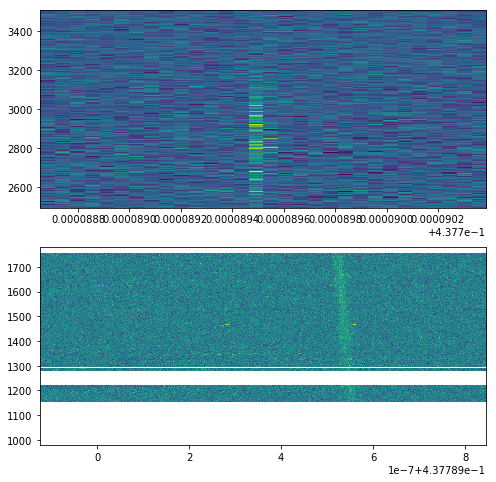

In [25]:
# put them together
fig = pl.figure(figsize=(8,8))
fig.add_subplot(211)
pl.imshow(specVLA.transpose(), interpolation='nearest', origin='bottom', extent=extent_vla, aspect='auto')
fig.add_subplot(212)
pl.imshow(specAO, interpolation='nearest', aspect='auto', extent=extent_ao)

In [26]:
tpk_vla = tbary_vla[np.where(specVLA.mean(axis=1) == specVLA.mean(axis=1).max())][0]
print('%.10f' % tpk_vla)

0.4377894891


## Regrid VLA and AO data to same fixed image grid

In [27]:
gap = 30
specregrid = np.zeros(shape=(nch1+st['nchan']+gap, len(tbary_ao)))

for idx in range(len(tbary_ao)):
    specregrid[254+gap:, idx] = specAO[:, idx]

idxs_vla = [np.argmin(np.abs(tbary_vla-tbary_ao[i])) for i in range(len(tbary_ao))]
for idx_ao in range(len(idxs_vla)):
    idx_vla = idxs_vla[idx_ao]
    specregrid[:254, idx_ao] += specVLA[idx_vla, ::-1]

## Plot it

[  0  80 160 240 320 400 480]


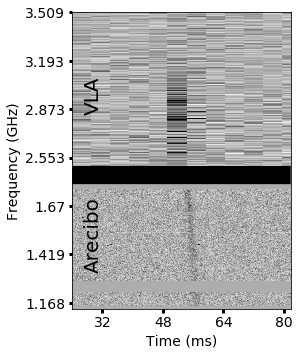

In [28]:
# assumes fixed relative gain between VLA and AO == 3
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(211)
pl.imshow(specregrid, interpolation='nearest', aspect='equal', vmax=0.8*specregrid.max(), cmap='Greys')#, vmin=-0.8)
ax.fill_between(np.arange(0, len(tbary_ao)), 254*np.ones(len(tbary_ao)), 
                (254+gap)*np.ones(len(tbary_ao)), facecolor='k')

pl.xlabel('Time (ms)', fontsize=14)
pl.ylabel('Frequency (GHz)', fontsize=14)
xticks = np.arange(0, 600, 100)
pl.xticks(xticks, np.array(tbin*2e-2*xticks, dtype='int'))
ntot = nch1+len(st['freq'])+gap
yticks = np.arange(0, ntot, 80)
print(yticks)
pl.yticks(yticks)
pl.yticks(yticks, [st['freq'][-1], st['freq'][-80], st['freq'][-160], st['freq'][-240],
                   np.round(1e-3*freqs_ao[ntot-320], 3), 
                   np.round(1e-3*freqs_ao[ntot-400], 3), 
                   np.round(1e-3*freqs_ao[ntot-480], 3)])
pl.xlim(150, len(tbary_ao))
pl.ylim(ntot-50, 0)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=3, color='k')
ax.yaxis.set_tick_params(width=3, color='k')
ax.text(170, 330, "Arecibo", rotation=90, fontsize=20)
ax.text(170, 130, "VLA", rotation=90, fontsize=20)
fig.savefig('aovla_spec.pdf', format='pdf')

## Calculate residual sweep and compare to DM model

In [29]:
# some residual dm sweep?
print(24*3600*(tbary_ao[np.where(specAO[128:].mean(axis=0) == specAO[128:].mean(axis=0).max())][0] -
               tbary_ao[np.where(specAO[:128].mean(axis=0) == specAO[:128].mean(axis=0).max())][0]))

dmt_ao_delta = dmdelay(dm0, obsfreq*1e-3, st['freq'][-1]) - dmdelay(560, obsfreq*1e-3, st['freq'][-1])
dmt_ao_inter = dmdelay(dm0, obsfreq*1e-3, (obsfreq-500)*1e-3) - dmdelay(560, obsfreq*1e-3, (obsfreq-500)*1e-3)
print(dmt_ao_delta, dmt_ao_inter)

0.00147730193518
(-0.0062022839361107751, 0.007798684063229699)


## Burst spectra with and without detections
### Compare Effelsberg, VLA, Arecibo measured burst fluxes and limits

In [30]:
# 4 bursts with ao, vla, effelsberg coverage
# (ami-la covers all 4 vla bursts)
# 57643 (AO-C, *VLA-S)
# 57645 (AO-L, *VLA-S)
# 57648 (*AO-L, *VLA-S, Eff-C)
# 57649 (AO-L, *VLA-S, Eff-C)
# * shows detections
# limits assume 2 ms pulse width

#s43d = np.array([[3.0, 4.0], [0.508, 0.0036*5]])
#s43l = np.array([[4.0], [0.0036*5]])  # useless data!
s45d = np.array([[1.38, 3.0], [0.002*5, (5/2.)*0.064]])
s45l = np.array([[1.38], [0.002*5]])  # too high?
s48d = np.array([[1.4, 3.0, 4.5], [0.057, (5/2.)*0.111, 0.028*5]])  # fixed for 2 ms width
s48l = np.array([[4.5], [0.028*5]])
s49d = np.array([[1.42, 3.0, 4.54], [0.002*5, (5/2.)*0.167, 0.028*5]])
s49l = np.array([[1.42, 4.54], [0.002*5, 0.028*5]])

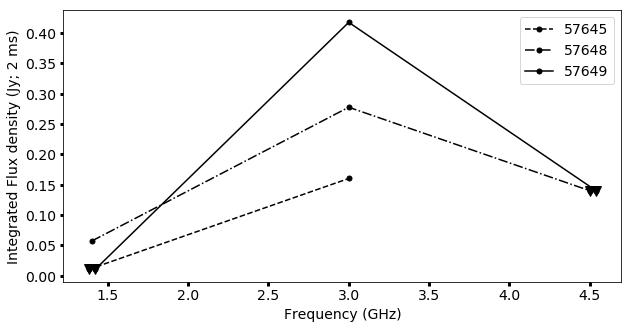

In [31]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# overplot upper limit symbols
#ax.plot(s43l[0], s43l[1], 'cv', ms=10)
ax.plot(s45l[0], s45l[1], 'kv', ms=10)
ax.plot(s48l[0], s48l[1], 'kv', ms=10)
ax.plot(s49l[0], s49l[1], 'kv', ms=10)
# plot lines with points first
#ax.plot(s43d[0], s43d[1], 'c.-', ms=10, label='12 Sep 2016')
ax.plot(s45d[0], s45d[1], 'k.--', ms=10, label='57645')
ax.plot(s48d[0], s48d[1], 'k.-.', ms=10, label='57648')
ax.plot(s49d[0], s49d[1], 'k.-', ms=10, label='57649')
ax.set_xlabel('Frequency (GHz)', fontsize=14)
ax.set_ylabel('Integrated Flux density (Jy; 2 ms)', fontsize=14)
ax.legend(fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=3, color='k')
ax.yaxis.set_tick_params(width=3, color='k')
fig.savefig('multispec.pdf', format='pdf')

## Calculate implied spectral index and limits

In [32]:
def speclim(s):
    freqs = s[0]
    fluxes = s[1]
    for i in range(len(freqs)-1):
        freqi = freqs[i]
        freqi1 = freqs[i+1]

        # correct for plotting offset
        if freqi <= 1.5:
            freqi = 1.4
        elif freqi1 > 4.2:
            freqi1 = 4.5

        print(freqi, freqi1)
        print(fluxes[i], fluxes[i+1])
        print(np.log10(fluxes[i]/fluxes[i+1])/np.log10(freqi/freqi1))

In [33]:
speclim(s45d)

(1.4, 3.0)
(0.01, 0.16)
3.63789924804


In [34]:
speclim(s48d)

(1.4, 3.0)
(0.057000000000000002, 0.27750000000000002)
2.07674384925
(3.0, 4.5)
(0.27750000000000002, 0.14000000000000001)
-1.68739182952


In [35]:
speclim(s49d)

(1.4, 3.0)
(0.01, 0.41750000000000004)
4.89634344931
(3.0, 4.5)
(0.41750000000000004, 0.14000000000000001)
-2.69478704784
